In [1]:

!pip install numpy


In [2]:
# !pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless
!pip install opencv-python-headless


In [3]:
!pip install  ultralytics easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/raw"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/anonymized"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Datathon/project/models/pii/face"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Datathon/project/models/pii/plate"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Datathon/project/src"


In [5]:
!wget -q -O "/content/drive/MyDrive/Colab Notebooks/Datathon/project/models/pii/face/deploy.prototxt" \
  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

!wget -q -O "/content/drive/MyDrive/Colab Notebooks/Datathon/project/models/pii/face/res10_300x300_ssd_iter_140000_fp16.caffemodel" \
  https://raw.githubusercontent.com/opencv/opencv_3rdparty/master/dnn_models/res10_300x300_ssd_iter_140000_fp16.caffemodel


In [6]:
from google.colab import files
uploaded = files.upload()  # choose your 'best.pt'

import shutil
if "best.pt" in uploaded:
    shutil.move("best.pt", "/content/drive/MyDrive/Colab Notebooks/Datathon/project/models/pii/plate/best.pt")


Saving best.pt to best.pt


In [7]:
%%writefile "/content/drive/MyDrive/Colab Notebooks/Datathon/project/src/utils_img.py"
import cv2 as cv
import numpy as np

def clamp_box(x1, y1, x2, y2, w, h):
    return max(0,x1), max(0,y1), min(w-1,x2), min(h-1,y2)

def expand_box(x1, y1, x2, y2, w, h, margin=0.15):
    bw, bh = (x2-x1), (y2-y1)
    mx, my = int(bw*margin), int(bh*margin)
    return clamp_box(x1-mx, y1-my, x2+mx, y2+my, w, h)

def blur_region(img, box, ksize=31):
    x1,y1,x2,y2 = box
    roi = img[y1:y2, x1:x2]
    if roi.size == 0: return img
    img[y1:y2, x1:x2] = cv.GaussianBlur(roi, (ksize,ksize), 0)
    return img

def pixelate_region(img, box, downscale=12):
    x1,y1,x2,y2 = box
    roi = img[y1:y2, x1:x2]
    if roi.size == 0: return img
    h,w = roi.shape[:2]
    small = cv.resize(roi, (max(1,w//downscale), max(1,h//downscale)), interpolation=cv.INTER_LINEAR)
    pix = cv.resize(small, (w,h), interpolation=cv.INTER_NEAREST)
    img[y1:y2, x1:x2] = pix
    return img


Overwriting /content/drive/MyDrive/Colab Notebooks/Datathon/project/src/utils_img.py


In [16]:
%%writefile "/content/drive/MyDrive/Colab Notebooks/Datathon/project/src/detectors.py"
import cv2 as cv
import numpy as np
import os

# ---------- Face Detector (Haar only -> no external weights, stable) ----------
class FaceDetector:
    def __init__(self, prototxt=None, caffemodel=None, conf=0.5):
        # Ignore prototxt/caffemodel; we use Haar cascade
        self.haar = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

    def detect(self, img):
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = self.haar.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(24,24))
        out = []
        for (x, y, w, h) in faces:
            out.append((int(x), int(y), int(x+w), int(y+h), 1.0))
        return out

# ---------- Text Detector (EasyOCR) ----------
class TextDetectorEasyOCR:
    def __init__(self, lang_list=['en'], gpu=False):
        import easyocr
        self.reader = easyocr.Reader(lang_list, gpu=gpu)

    def detect(self, img, min_box=10):
        rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.reader.readtext(rgb, detail=1, paragraph=False)
        out = []
        H, W = img.shape[:2]
        for (box, text, conf) in results:
            xs = [int(p[0]) for p in box]
            ys = [int(p[1]) for p in box]
            x1, y1, x2, y2 = max(0, min(xs)), max(0, min(ys)), min(W-1, max(xs)), min(H-1, max(ys))
            if (x2-x1) >= min_box and (y2-y1) >= min_box:
                out.append((x1, y1, x2, y2, float(conf)))
        return out

# ---------- License Plate Detector (YOLOv8) ----------
class PlateDetectorYOLO:
    def __init__(self, weights_path, conf=0.25, iou=0.5):
        from ultralytics import YOLO
        if not os.path.exists(weights_path):
            self.model = None
        else:
            self.model = YOLO(weights_path)
        self.conf = conf; self.iou = iou

    def detect(self, img):
        if self.model is None:
            return []
        res = self.model.predict(source=img, conf=self.conf, iou=self.iou, verbose=False)[0]
        boxes = []
        H, W = img.shape[:2]
        if res.boxes is not None:
            for b in res.boxes:
                x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().astype(int).tolist()
                c = float(b.conf[0].cpu().numpy())
                x1, y1, x2, y2 = max(0, x1), max(0, y1), min(W-1, x2), min(H-1, y2)
                if x2 > x1 and y2 > y1:
                    boxes.append((x1, y1, x2, y2, c))
        return boxes


Overwriting /content/drive/MyDrive/Colab Notebooks/Datathon/project/src/detectors.py


In [9]:
%%writefile "/content/drive/MyDrive/Colab Notebooks/Datathon/project/src/anonymize.py"
import cv2 as cv
from pathlib import Path
from tqdm import tqdm
from detectors import FaceDetector, TextDetectorEasyOCR, PlateDetectorYOLO
from utils_img import expand_box, blur_region, pixelate_region

BASE_DIR = Path(__file__).resolve().parent.parent
FACE_PROTO = BASE_DIR / "models/pii/face/deploy.prototxt"
FACE_MODEL = BASE_DIR / "models/pii/face/res10_300x300_ssd_iter_140000_fp16.caffemodel"
PLATE_MODEL = BASE_DIR / "models/pii/plate/best.pt"

def redact(img, boxes, mode="blur", margin=0.2, blur_ksize=31, pixel_downscale=12):
    H, W = img.shape[:2]
    out = img.copy()
    for (x1, y1, x2, y2, _) in boxes:
        X1, Y1, X2, Y2 = expand_box(x1, y1, x2, y2, W, H, margin)
        if mode == "blur":
            out = blur_region(out, (X1, Y1, X2, Y2), ksize=blur_ksize)
        else:
            out = pixelate_region(out, (X1, Y1, X2, Y2), downscale=pixel_downscale)
    return out

def process_dir(in_dir, out_dir,
                face_conf=0.5, face_margin=0.28, face_mode="blur",
                text_minbox=12, text_margin=0.15, text_mode="pixel",
                plate_conf=0.25, plate_iou=0.5, plate_margin=0.25, plate_mode="pixel",
                use_face=True, use_text=True, use_plate=True):

    in_dir = Path(in_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    face = FaceDetector(str(FACE_PROTO), str(FACE_MODEL), conf=face_conf) if use_face else None
    text = TextDetectorEasyOCR(lang_list=['en'], gpu=False) if use_text else None
    plate = PlateDetectorYOLO(str(PLATE_MODEL), conf=plate_conf, iou=plate_iou) if use_plate else None

    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    images = [p for p in in_dir.rglob("*") if p.suffix.lower() in exts]
    for src in tqdm(images, desc="Anonymizing"):
        rel = src.relative_to(in_dir)
        dst = out_dir / rel
        dst.parent.mkdir(parents=True, exist_ok=True)
        img = cv.imread(str(src))
        if img is None:
            continue

        face_boxes = face.detect(img) if face else []
        text_boxes = text.detect(img, min_box=text_minbox) if text else []
        plate_boxes = plate.detect(img) if plate else []

        work = img.copy()
        if face:
            work = redact(work, face_boxes, mode=face_mode, margin=face_margin)
        if text:
            work = redact(work, text_boxes, mode=text_mode, margin=text_margin)
        if plate:
            work = redact(work, plate_boxes, mode=plate_mode, margin=plate_margin)

        cv.imwrite(str(dst), work)

    return True


Overwriting /content/drive/MyDrive/Colab Notebooks/Datathon/project/src/anonymize.py


In [15]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Datathon/project/src")


In [17]:
import importlib, detectors, anonymize
importlib.reload(detectors)
importlib.reload(anonymize)


<module 'anonymize' from '/content/drive/MyDrive/Colab Notebooks/Datathon/project/src/anonymize.py'>

In [18]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Datathon/project/src")
import importlib, detectors, anonymize
importlib.reload(detectors)
importlib.reload(anonymize)


<module 'anonymize' from '/content/drive/MyDrive/Colab Notebooks/Datathon/project/src/anonymize.py'>

In [21]:
from anonymize import process_dir

process_dir(
    in_dir="/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/raw",          # input folder with original images
    out_dir="/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/anonymized",  # output folder for anonymized images
    use_face=True,   # blur faces
    use_text=True,   # blur text (including most plates)
    use_plate=True   # set True if you have best.pt for YOLO plate detection, else False
)


Anonymizing: 100%|██████████| 3/3 [01:24<00:00, 28.15s/it]


True

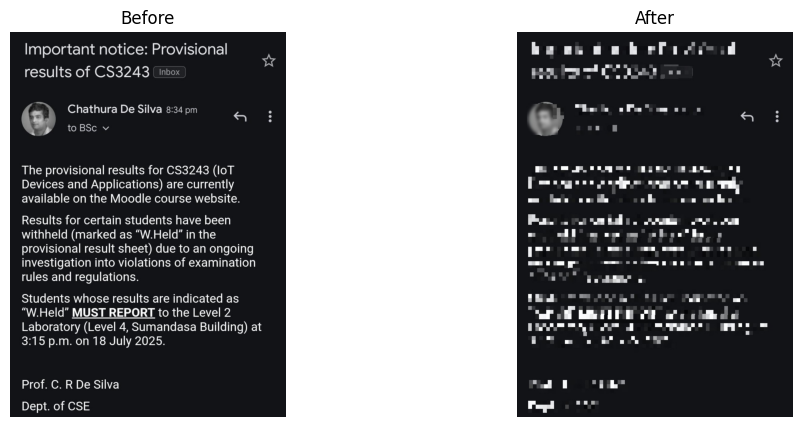

In [22]:
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path

raw_dir = Path("/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/raw")
anon_dir = Path("/content/drive/MyDrive/Colab Notebooks/Datathon/project/data/anonymized")

# Pick first matching file
first_file = next(raw_dir.glob("**/*.*"))
anon_file = anon_dir / first_file.relative_to(raw_dir)

before = cv.cvtColor(cv.imread(str(first_file)), cv.COLOR_BGR2RGB)
after = cv.cvtColor(cv.imread(str(anon_file)), cv.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(before); plt.title("Before"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(after); plt.title("After"); plt.axis('off')
plt.show()
